In [1]:
import pickle
import tempfile
import numpy as np
import tensorflow as tf
from get_data import *
from attention import Attention
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
MAX_SEQ_LEN = 42
EMBEDDING_DIM = 300
VOCAB_SIZE = 20000

In [4]:
data = read_data()
train_data = data[:3]
test_data = data[3:]

In [5]:
train_data, embed_matrix = preprocess_traindata(train_data, MAX_SEQ_LEN, EMBEDDING_DIM, VOCAB_SIZE)

Non labelled: 785
Contradiction: 183187
Neutral: 182764
Entailment: 183416


In [6]:
train_data[0].shape

(549367, 42)

In [7]:
train_data[1].shape

(549367, 42)

In [8]:
train_data[2].shape

(549367, 3)

In [9]:
embedding =  tf.keras.layers.Embedding(embed_matrix.shape[0], output_dim=EMBEDDING_DIM, weights=[embed_matrix], input_length=MAX_SEQ_LEN, trainable=False)

In [10]:
lam = tf.keras.regularizers.l2(l2=0.00001)

In [11]:
# Define the input layers and its shapes for premise and hypothesis
premise = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype='int32')
hypothesis = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype='int32')

In [12]:
premise.shape, hypothesis.shape

(TensorShape([None, 42]), TensorShape([None, 42]))

In [13]:
# Embed the premise and hypothesis
premise_embedded = embedding(premise)
hypothesis_embedded = embedding(hypothesis)

In [14]:
premise_embedded.shape, hypothesis_embedded.shape

(TensorShape([None, 42, 300]), TensorShape([None, 42, 300]))

In [15]:
# Add a time distributed translation layer for better performance
# Time distributed layer applies the same Dense layer to each temporal slice of input
translation = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(300, activation='relu', kernel_regularizer=lam))

In [16]:
# Apply the translation layer
premise_translated = translation(premise_embedded)
hypothesis_translated = translation(hypothesis_embedded)

In [17]:
premise_translated.shape, hypothesis_translated.shape

(TensorShape([None, 42, 300]), TensorShape([None, 42, 300]))

In [18]:
# Bidirectional LSTM layer
BiLSTM = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, kernel_regularizer=lam, recurrent_regularizer=lam, return_sequences=True))

In [19]:
# Apply the bidirectional LSTM layer
premise_BiLSTM = BiLSTM(premise_translated)
hypothesis_BiLSTM = BiLSTM(hypothesis_translated)

In [20]:
premise_BiLSTM.shape, hypothesis_BiLSTM.shape

(TensorShape([None, 42, 200]), TensorShape([None, 42, 200]))

In [21]:
# Apply Batch normalization
# premise_normalized = tf.keras.layers.BatchNormalization()(premise_BiLSTM)
# hypothesis_normalized = tf.keras.layers.BatchNormalization()(hypothesis_BiLSTM)

In [22]:
# Apply Attention
# premise_attention = tf.keras.layers.AdditiveAttention()()
# hypothesis_attention
_, premise_attention = Attention(return_sequences=False)(premise_BiLSTM)
_, hypothesis_attention = Attention(return_sequences=False)(hypothesis_BiLSTM)

In [23]:
premise_attention.shape, hypothesis_attention.shape

(TensorShape([None, 200]), TensorShape([None, 200]))

In [24]:
# Concatenate the premise and hypothesis and apply a dropout layer
train_input = tf.keras.layers.concatenate([premise_attention, hypothesis_attention])
train_input = tf.keras.layers.Dropout(0.1)(train_input)

In [25]:
train_input.shape

TensorShape([None, 400])

In [26]:
train_input = tf.keras.layers.Dense(200, kernel_regularizer=lam)(train_input)
train_input = tf.keras.layers.BatchNormalization()(train_input)
train_input = tf.keras.layers.ReLU()(train_input)
train_input = tf.keras.layers.Dropout(0.1)(train_input)

train_input = tf.keras.layers.Dense(200, kernel_regularizer=lam)(train_input)
train_input = tf.keras.layers.BatchNormalization()(train_input)
train_input = tf.keras.layers.ReLU()(train_input)
train_input = tf.keras.layers.Dropout(0.1)(train_input)

train_input = tf.keras.layers.Dense(200, kernel_regularizer=lam)(train_input)
train_input = tf.keras.layers.BatchNormalization()(train_input)
train_input = tf.keras.layers.ReLU()(train_input)
train_input = tf.keras.layers.Dropout(0.1)(train_input)

In [27]:
# Define the output Dense layer
prediction = tf.keras.layers.Dense(3, activation='softmax')(train_input)

In [28]:
# Define the complete model
model = tf.keras.models.Model(inputs=[premise, hypothesis], outputs=prediction)

# Choosing an optimizer
optimizer = tf.keras.optimizers.RMSprop(lr=0.01)

# Compile the model and print out the model summary
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 300)      7802100     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 42, 300)      90300       embedding[0][0]              

In [29]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

_, tmpfn = tempfile.mkstemp()
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(tmpfn, save_best_only=True, save_weights_only=True)

callbacks = [model_checkpoint, learning_rate_reduction, early_stopping]

In [30]:
# Train the model
history = model.fit(x=[train_data[0], train_data[1]], y=train_data[2], batch_size=512, epochs=5, validation_split=0.02, callbacks=callbacks)

Epoch 1/5
1052/1052 [==============================] - 188s 165ms/step - loss: 0.8874 - accuracy: 0.5868 - val_loss: 0.7098 - val_accuracy: 0.7053
Epoch 2/5
1052/1052 [==============================] - 176s 167ms/step - loss: 0.7045 - accuracy: 0.7084 - val_loss: 0.6473 - val_accuracy: 0.7427
Epoch 3/5
1052/1052 [==============================] - 185s 176ms/step - loss: 0.6503 - accuracy: 0.7415 - val_loss: 0.6248 - val_accuracy: 0.7563
Epoch 4/5
1052/1052 [==============================] - 175s 166ms/step - loss: 0.6244 - accuracy: 0.7554 - val_loss: 0.6171 - val_accuracy: 0.7647
Epoch 5/5
1052/1052 [==============================] - 173s 164ms/step - loss: 0.6035 - accuracy: 0.7672 - val_loss: 0.6075 - val_accuracy: 0.7658


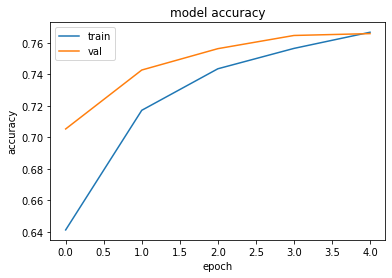

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.xticks([i for i in range(25)])
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('./figures/model_acc_0.00001_0.1_1_100_300D.png')
plt.show()

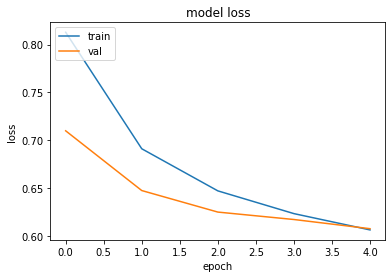

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.xticks([i for i in range(25)])
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('./figures/model_loss_0.00001_0.1_1_100_300D.png')
plt.show()

In [61]:
# model.save('./Trained Models/baseline_0.00001_0.1_1_100_300D.h5')

In [33]:
test_data = data[3:]
test_data = preprocess_testdata(test_data, MAX_SEQ_LEN)

Non labelled: 176
Contradiction: 3237
Neutral: 3219
Entailment: 3368


In [6]:
# try:
#     model = tf.keras.models.load_model('./Trained Models/baseline_0.00001_0.1_1_100_300D.h5')
# except:
#     print("Trained model does not exist. Please train the model.\n")
#     exit(0)

In [34]:
loss, accuracy = model.evaluate(x=[test_data[0], test_data[1]], y=test_data[2], batch_size=256)
print("Test Loss: {:.2f}, Test Accuracy: {:.2f}%\n".format(loss, (accuracy*100)))

39/39 [==============================] - 2s 41ms/step - loss: 0.5826 - accuracy: 0.7821
Test Loss: 0.58, Test Accuracy: 78.21%



In [35]:
Y_pred = model.predict([test_data[0], test_data[1]])
Y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(test_data[2], axis=1)

In [36]:
Y_test

array([1, 2, 0, ..., 0, 2, 1], dtype=int64)

In [37]:
Y_pred

array([0, 2, 0, ..., 0, 2, 1], dtype=int64)

Text(51.0, 0.5, 'Predicted labels')

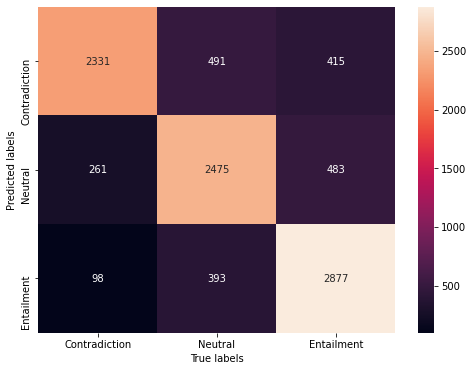

In [38]:
plt.figure(figsize=(8, 6))
ticks = ['Contradiction', 'Neutral', 'Entailment']
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='g', xticklabels=ticks, yticklabels=ticks)
plt.xlabel("True labels")
plt.ylabel("Predicted labels")
# plt.savefig('./figures/model_conf_0.00001_0.1_1_100_300D.png')

<AxesSubplot:>

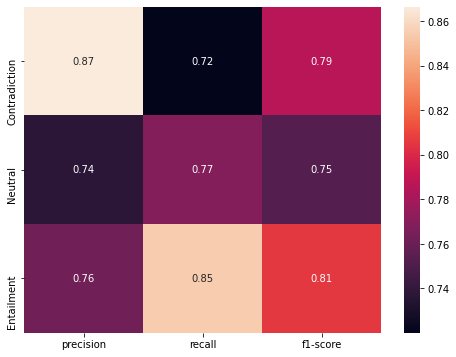

In [39]:
plt.figure(figsize=(8, 6))
report = classification_report(Y_test, Y_pred, output_dict=True, target_names=ticks)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :3].T, annot=True)
# plt.savefig('./figures/model_metrics_0.00001_0.1_1_100_300D.png')